In [29]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, butter_lowpass, SNR_plot_vanilla
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm

In [2]:
# Create Data

def get_data(num_symbols=10000):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35, norm_h=False)

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    #X_tx = X_tx / torch.sqrt(torch.mean(torch.square(X_tx)))

    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y, CS

In [3]:
# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss

Xtrain, ytrain, CS = get_data(num_symbols=10000)

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

0.8944271909999159
Using CPU
299  loss: 0.4858887195587158
299  acc: 0.8058000206947327


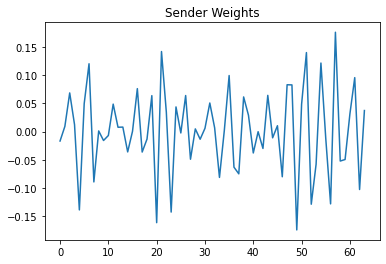

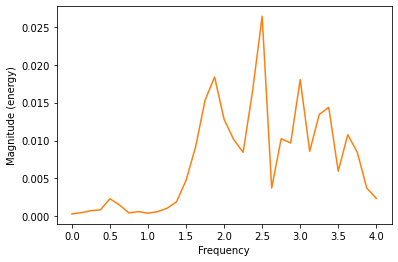

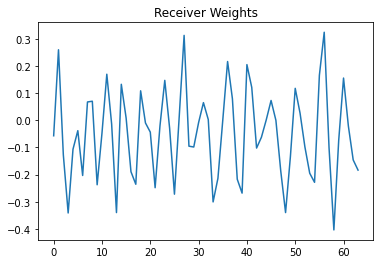

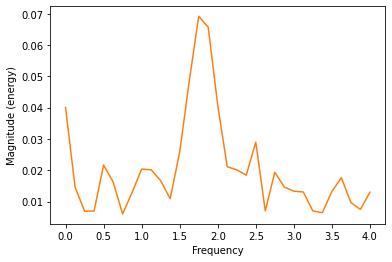

599  loss: 0.3945528566837311
599  acc: 0.8400999903678894


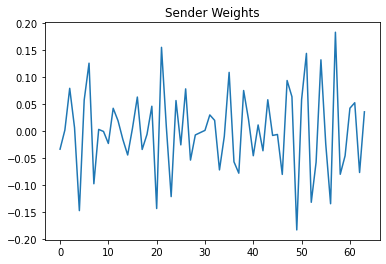

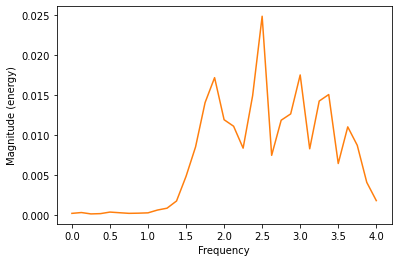

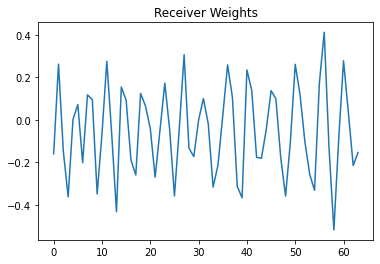

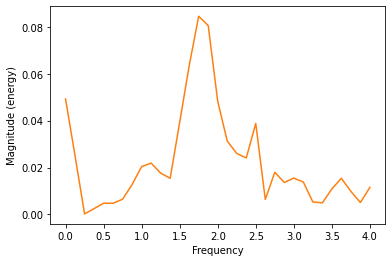

899  loss: 0.3397051990032196
899  acc: 0.8702999949455261


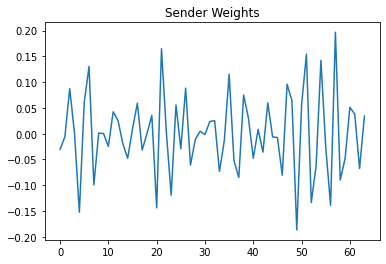

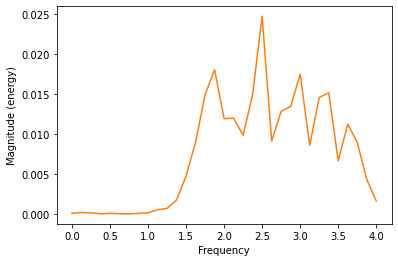

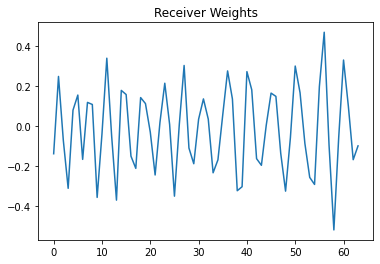

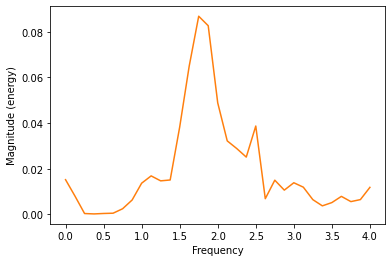

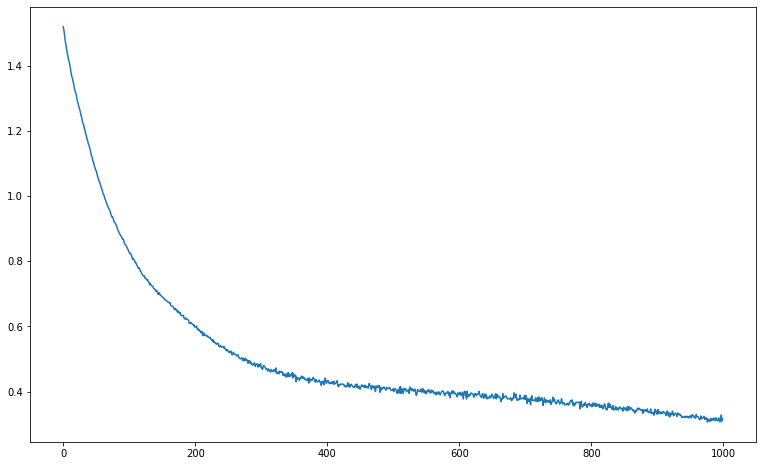

In [4]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, lowpass=True,
                                sample_rate=CS.m, epochs=1000, cutoff_freq=2, v=True, use_cuda=False, SNRdb=10)

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [35]:
# Evaluate

def transmit_joint(SNRdb, Xtest, ytest, CS, cutoff_freq):
    
    SNR = 10 ** (SNRdb / 10)
    sigma = np.sqrt(8 / SNR)
    print("sigma:", sigma)
    

    classes = np.array(CS.symbol_set)
    b, a = butter_lowpass(cutoff_freq, CS.m, 4)
    b = torch.tensor(b, requires_grad=True).float()
    a = torch.tensor(a, requires_grad=True).float()

    # upsample symbol sequence and filter it on transmission side VIA a neural network
    upsampled = CS.upsample()
    upsampled = torch.tensor(upsampled).view(1, 1, -1).float()

    Tx = NN_tx(upsampled)


    #Send filtered signal through lowpass filter
    Tx = torchaudio.functional.lfilter(Tx, a, b)
    Tx = Tx / torch.sqrt(torch.mean(torch.square(Tx)))
    Tx = Tx + torch.normal(0.0, sigma, Tx.shape)  # add gaussian noise
    Tx = torch.Tensor(Tx)

    output = NN_rx(Tx)[0].T
    decisions = classes[output.argmax(axis=1)]
    
    return decisions
    
    #return 1-CStest.evaluate(decisions)[1]

    #print('Acc:', 1 - CS.evaluate(decisions)[1])
    
Xtest, ytest, CStest = get_data(num_symbols=10000)
joint_decisions = transmit_joint(SNRdb=7, Xtest=Xtest, ytest=ytest, CS=CStest, cutoff_freq=2)
CStest.evaluate(joint_decisions)[1]

sigma: 1.2634119882188486


0.2425

In [36]:
symbol_set = [3, 1, -1, -3]  # all symbols that we use
num_symbols = 1000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35, norm_h=False)

SNRdbs = np.linspace(0, 18, 50)
sigmas = []
euclid_error_rates = []
network_error_rates = []
avg_symbol_energy = np.mean(np.array(symbol_seq) ** 2)
print('Avg symbol energy', avg_symbol_energy)
gain_factor = np.max(np.convolve(CS.h, CS.h))
print('gain', gain_factor)
Xtest, ytest, CStest = get_data(num_symbols=10000)

for SNRdb in SNRdbs:
    sigma_euclid = CS.SNRdb_to_sigma(SNRdb, avg_symbol_energy, use_gain=True) # symbol energy og gain
    sigma_network = CS.SNRdb_to_sigma(SNRdb, 8, use_gain=False) # fordi vi har normaliseret er sample energi sat til 1, og vi har 8 samples pr symbol, er avg_symbol_energy så 1*8
    euclid_decisions = CS.transmission(noise_level=sigma_euclid, norm_signal=False, v=False)
    joint_decisions = transmit_joint(SNRdb, Xtest, ytest, CStest, cutoff_freq=2)
    CStest.evaluate(joint_decisions)[1]
    
    #network_decisions = CS.transmission(mode='network', noise_level=sigma_network, norm_signal=True, v=False, model=model)
    sigmas.append(sigma_euclid)

    euclid_error_rates.append(CS.evaluate(euclid_decisions)[1])
    network_error_rates.append(CStest.evaluate(joint_decisions)[1])

sigmas = np.array(sigmas)
error_theory = 1.5 * (1 - norm.cdf(np.sqrt(gain_factor / sigmas ** 2)))
euclid_error_rates = np.array(euclid_error_rates)
network_error_rates = np.array(network_error_rates)

Avg symbol energy 5.112
gain 7.9976510763715565
sigma: 2.8284271247461903
sigma: 2.711300452553287
sigma: 2.5990240581769686
sigma: 2.4913970890321013
sigma: 2.3882270099459726
sigma: 2.2893292587298157
sigma: 2.1945269160133027
sigma: 2.103650388751368
sigma: 2.0165371068371787
sigma: 1.9330312322785266
sigma: 1.8529833804173805
sigma: 1.776250352693882
sigma: 1.7026948804767308
sigma: 1.6321853795016867
sigma: 1.5645957144789053
sigma: 1.4998049734480094
sigma: 1.4376972514772357
sigma: 1.378161443319717
sigma: 1.3210910446559747
sigma: 1.2663839615670702
sigma: 1.2139423278975705
sigma: 1.163672330181611
sigma: 1.1154840398188661
sigma: 1.0692912522001983
sigma: 1.025011332495203
sigma: 0.9825650678257712
sigma: 0.9418765255612241
sigma: 0.9028729174815217
sigma: 0.8654844695655451
sigma: 0.8296442971715158
sigma: 0.7952882853862591
sigma: 0.7623549743292697
sigma: 0.7307854492063955
sigma: 0.700523234916458
sigma: 0.6715141950222677
sigma: 0.6437064349053043
sigma: 0.61705020893081

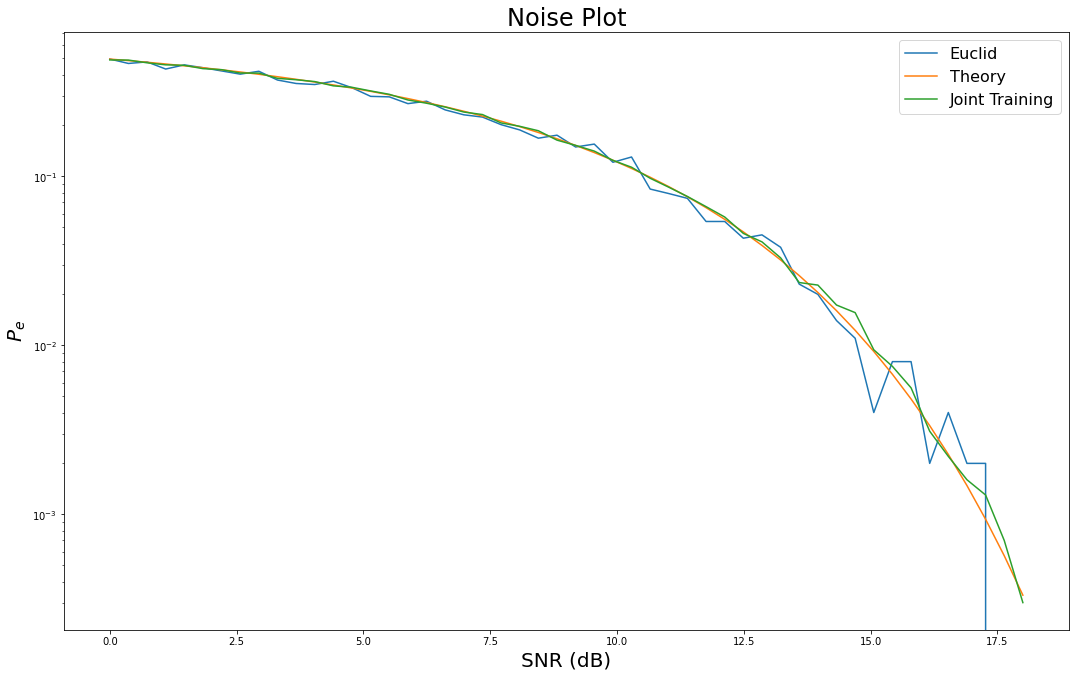

In [37]:
plt.figure(figsize=(18, 11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
plt.semilogy(SNRdbs, euclid_error_rates)
plt.semilogy(SNRdbs, error_theory)
plt.semilogy(SNRdbs, network_error_rates)

legend = ['Euclid', 'Theory', 'Joint Training']
plt.legend(legend, fontsize=16)
plt.show()

In [ ]:
Xtest, ytest, CStest = get_data(num_symbols=10000)

sigmas = np.linspace(0.25, 1.75, 50)

#sigmas = np.linspace(0.75, 4.5, 50) #sigmas = np.linspace(2.5, 4.5, 500)#
SNRs = []
error_rates_joint = []
error_rates_euclid = []
avg_symbol_energy = np.mean(np.array(CStest.symbol_seq)**2)
gain_factor = np.max(np.convolve(CStest.h, CStest.h))
print(gain_factor)

for sigma in sigmas:

    error_rates_joint.append( evaluate_yo(sigma, Xtest, ytest, CStest, 2) )
    received_symbols_euclid = CStest.transmission(mode='euclidean', noise_level=sigma)
    SNRs.append(avg_symbol_energy/(sigma**2))
    error_rates_euclid.append(CStest.evaluate(received_symbols_euclid)[1])

SNRsDB = 10*np.log10(SNRs)
error_rates_joint = np.array(error_rates_joint)
error_rates_euclid = np.array(error_rates_euclid)
error_theory = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(gain_factor/sigmas**2)))

In [ ]:
plt.figure(figsize=(13,8))
plt.title('Decision-Making Noise Plots', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRsDB, error_rates_euclid)
plt.semilogy(SNRsDB[num:], error_rates_joint[num:])
plt.semilogy(SNRsDB, error_theory)
legend = ['Euclidean', 'Sender AND Receiver Network', 'Theory']
legend2 = ['Euclidean', 'Theory']
plt.legend(legend2, fontsize=16)
#plt.ylim([1e-3, 1])
plt.show()